<a href="https://colab.research.google.com/github/Bailior0/Cleaner/blob/main/deep_learning_42_milestone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***This is a homework assignment in "Deep Learning in Practice: Based on Python and Lua".***  

We'll develop image-based algorithms to identify histologically confirmed skin cancer cases with single-lesion crops from 3D total body photos.

***The team members are:***

* Gyulai Gergő László
* Horváth Ágoston
* Frink Dávid

You can read more information about our chosen homework at the link below:  
https://www.kaggle.com/competitions/isic-2024-challenge

# Download and setup

Download the Kaggle Python library.

In [ ]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=7c340e11c9ad6e9cdc0690538113ffea4a92f077d1fbeef36079ee99bf1aae6c
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


Configure Kaggle to access the API  
**Warning!** You need to copy your own kaggle.json file into Colab in order to validate yourself.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download the required dataset.

In [ ]:
!kaggle competitions download -c isic-2024-challenge

100% 2.00G/2.00G [00:31<00:00, 85.7MB/s]
100% 2.00G/2.00G [00:31<00:00, 69.1MB/s]


Extracting the data.

**Warning!** This process might take a few minutes

In [ ]:
!unzip isic-2024-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: train-image/image/ISIC_9874656.jpg  
  inflating: train-image/image/ISIC_9874659.jpg  
  inflating: train-image/image/ISIC_9874663.jpg  
  inflating: train-image/image/ISIC_9874742.jpg  
  inflating: train-image/image/ISIC_9874751.jpg  
  inflating: train-image/image/ISIC_9874803.jpg  
  inflating: train-image/image/ISIC_9874805.jpg  
  inflating: train-image/image/ISIC_9874832.jpg  
  inflating: train-image/image/ISIC_9874878.jpg  
  inflating: train-image/image/ISIC_9874897.jpg  
  inflating: train-image/image/ISIC_9874925.jpg  
  inflating: train-image/image/ISIC_9874931.jpg  
  inflating: train-image/image/ISIC_9874939.jpg  
  inflating: train-image/image/ISIC_9874940.jpg  
  inflating: train-image/image/ISIC_9874963.jpg  
  inflating: train-image/image/ISIC_9874987.jpg  
  inflating: train-image/image/ISIC_9875007.jpg  
  inflating: train-image/image/ISIC_9875010.jpg  
  inflating: train-image/image/ISIC_9875033.jpg  

# Preparing train, test and valid dataset

Gathering information about the dataset based on the provided metadata.

In [ ]:
import pandas as pd

Loading the train-metadata.csv dataset. This file contains general information about the samples.

In [ ]:
metadata = pd.read_csv('train-metadata.csv')
metadata.head()

<ipython-input-6-4c180bfb1031>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


Let's examine the number of benign and malignant instances. Later, we'll balance the distribution using certain techniques.

In [ ]:
benign_data = metadata[metadata['target'] == 0]
malignant_data = metadata[metadata['target'] == 1]

print(f'Benign images: {len(benign_data)}')
print(f'Malignant images: {len(malignant_data)}')

Benign images: 400666
Malignant images: 393


Selecting the IDs of each data entry. But we will use IDs to identify samples, and later the data generator will handle the IDs properly.

In [ ]:
benign_ids = benign_data['isic_id'].tolist()
malignant_ids = malignant_data['isic_id'].tolist()

print(f'Benign images ids: {benign_ids[:5]}')
print(f'Malignant images ids: {malignant_ids[:5]}')

Benign images ids: ['ISIC_0015670', 'ISIC_0015845', 'ISIC_0015864', 'ISIC_0015902', 'ISIC_0024200']
Malignant images ids: ['ISIC_0082829', 'ISIC_0096034', 'ISIC_0104229', 'ISIC_0119495', 'ISIC_0157834']


Generating the validation, training, and test datasets for each class.

In [ ]:
test_split = 0.1
valid_split = 0.1

test_benign_ids = benign_ids[:int(len(benign_ids) * test_split)]
test_malignant_ids = malignant_ids[:int(len(malignant_ids) * test_split)]

valid_benign_ids = benign_ids[int(len(benign_ids) * test_split):int(len(benign_ids) * (test_split + valid_split))]
valid_malignant_ids = malignant_ids[int(len(malignant_ids) * test_split):int(len(malignant_ids) * (test_split + valid_split))]

train_benign_ids = benign_ids[int(len(benign_ids) * (test_split + valid_split)):]
train_malignant_ids = malignant_ids[int(len(malignant_ids) * (test_split + valid_split)):]

test_ids = test_benign_ids + test_malignant_ids
valid_ids = valid_benign_ids + valid_malignant_ids
train_ids = train_benign_ids + train_malignant_ids

print(f'Test benign images: {len(test_benign_ids)}')
print(f'Test malignant images: {len(test_malignant_ids)}\n')
print(f'Valid benign images: {len(valid_benign_ids)}')
print(f'Valid malignant images: {len(valid_malignant_ids)}\n')
print(f'Train benign images: {len(train_benign_ids)}')
print(f'Train malignant images: {len(train_malignant_ids)}')

Test benign images: 40066
Test malignant images: 39

Valid benign images: 40067
Valid malignant images: 39

Train benign images: 320533
Train malignant images: 315


### Creating sample datasets

Our goal is to train another model based on the metadata. If both models return 'true,' it is probable that the lesion is malignant. In this step, we will select the relevant metadata for that model.

In [ ]:
COLUMNS = [
    'clin_size_long_diam_mm',
    'tbp_lv_areaMM2',
    'tbp_lv_area_perim_ratio',
    'tbp_lv_color_std_mean',
    'tbp_lv_deltaLBnorm',
    'tbp_lv_minorAxisMM',
    'tbp_lv_perimeterMM'
]

display(malignant_data[COLUMNS].head())
display(benign_data[COLUMNS].head())

,clin_size_long_diam_mm,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaLBnorm,tbp_lv_minorAxisMM,tbp_lv_perimeterMM
387,9.27,40.964534,25.940259,3.287692,12.342322,6.677133,32.598015
935,3.88,6.192531,30.648580,0.624458,5.716512,2.710643,13.776510
1245,6.55,12.103580,38.025960,1.401430,5.621653,3.481341,21.453450
1846,5.27,13.267030,30.444160,1.472167,5.481429,3.573096,20.097350
3478,5.29,15.049728,24.313243,2.243673,7.399501,4.222128,19.128714


,clin_size_long_diam_mm,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaLBnorm,tbp_lv_minorAxisMM,tbp_lv_perimeterMM
0,3.04,3.152561,27.476170,0.00000,5.784302,1.543016,9.307003
1,1.10,0.919497,12.235290,0.00000,4.987244,0.821918,3.354148
2,3.40,3.265153,24.184620,0.00000,6.290359,1.194905,8.886309
3,3.22,6.079940,14.889242,0.51452,6.400196,2.481328,9.514499
4,2.73,2.101708,19.902560,0.00000,6.531302,0.929916,6.467562


In this section, we construct a sample dataset to make the fitting, validating, and testing processes faster later. The distribution between the datasets doesn’t matter, as it’s just for model testing. Later, we'll use IDs to identify the metadata and images of the samples, and we'll index this metadata and these images from the original dataset.

In [ ]:
import random

sample_size = 10000

train_benign_sample_ids = random.sample(train_benign_ids, k=sample_size)
train_malignant_sample_ids = random.sample(train_malignant_ids, k=int(sample_size/1000))

valid_benign_sample_ids = random.sample(valid_benign_ids, k=int(sample_size * 0.1))
valid_malignant_sample_ids = random.sample(valid_malignant_ids, k=int(sample_size/1000))

test_benign_sample_ids = random.sample(test_benign_ids, k=int(sample_size * 0.1))
test_malignant_sample_ids = random.sample(test_malignant_ids, k=int(sample_size/1000))

train_sample_ids = train_benign_sample_ids + train_malignant_sample_ids
valid_sample_ids = valid_benign_sample_ids + valid_malignant_sample_ids
test_sample_ids = test_benign_sample_ids + test_malignant_sample_ids

print(f"train_benign_sample_ids size: {len(train_benign_sample_ids)}")
print(f"train_malignant_sample_ids size: {len(train_malignant_sample_ids)}\n")

print(f"valid_benign_sample_ids size: {len(valid_benign_sample_ids)}")
print(f"valid_malignant_sample_ids size: {len(valid_malignant_sample_ids)}\n")

print(f"test_benign_sample_ids size: {len(test_benign_sample_ids)}")
print(f"test_malignant_sample_ids size: {len(test_malignant_sample_ids)}")

train_benign_sample_ids size: 10000
train_malignant_sample_ids size: 10

valid_benign_sample_ids size: 1000
valid_malignant_sample_ids size: 10

test_benign_sample_ids size: 1000
test_malignant_sample_ids size: 10


### Loadig the images

Required libraries for visualization and image preprocessing.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import io
import matplotlib.image as mpimg
import h5py

Visualizing some of the downloaded images.

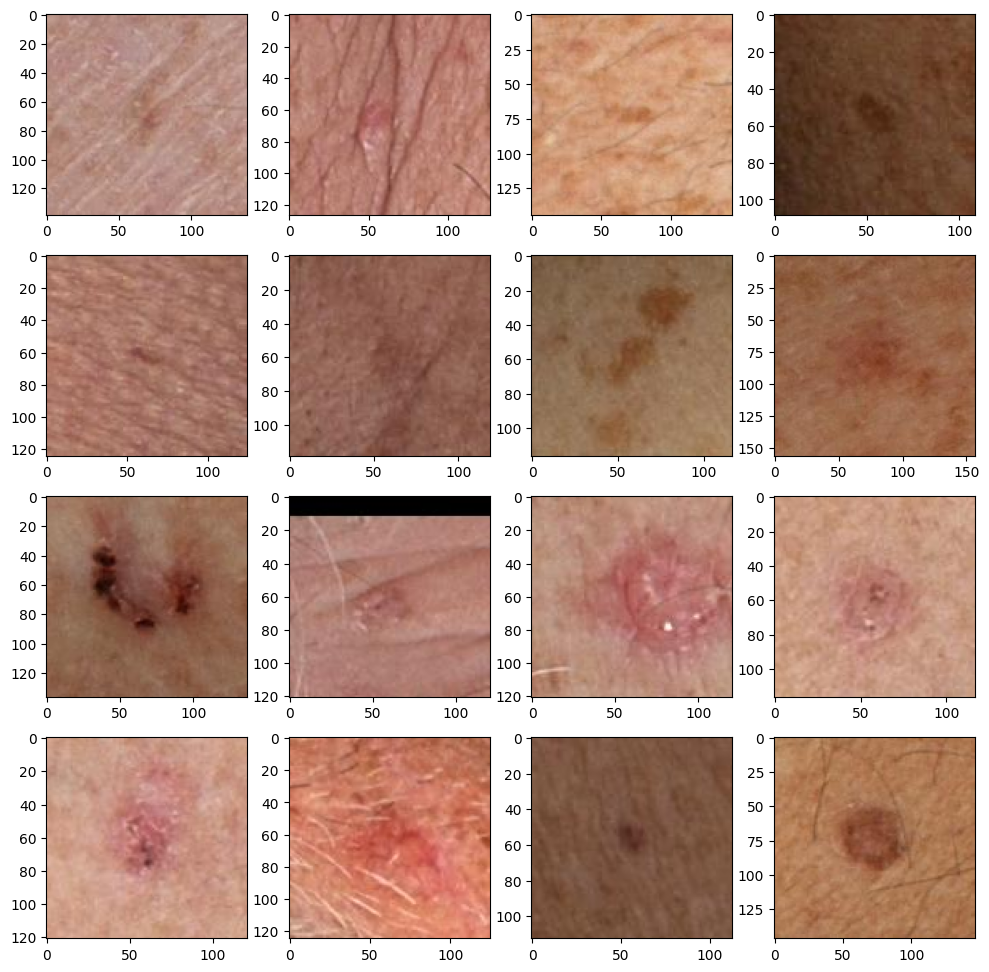

In [ ]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

next_benign_pix = [key for key in benign_ids[:int(ncols*nrows/2)]]
next_malignant_pix = [key for key in malignant_ids[:int(ncols*nrows/2)]]

with h5py.File('train-image.hdf5', 'r') as f:
  for i, img_key in enumerate(next_benign_pix + next_malignant_pix):
    image_data = f[img_key][()]
    image = Image.open(io.BytesIO(image_data))

    sp = plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)

plt.show()